<h1><center>DSA 4212: Year 2022</center></h1>
<h3><center> Assignment 1 (Deadline: Sunday 27th March at 23:59) </center></h3>
<h4><center> Group Number: ???? </center></h4>
<h4><center> Filename: assignment_1_XX.ipynb where XX is your group number</center></h4>
<h4><center> Group Member 1: Student Name, Student ID </center></h4>
<h4><center> Group Member 2: Student Name, Student ID </center></h4>
<h4><center> Group Member 3: Student Name, Student ID </center></h4>
<h4><center> Group Member 4: Student Name, Student ID </center></h4>

**Remark:** as described below, each group has to submit two documents on lumiNUS: 
1. a jupyter notebook with your code  
2. a pdf report explaining your approaches and conclusions.
3. you can have a look at `https://www.overleaf.com/read/xmvqgpsdqwyx` if you would like to use Overleaf and Latex to rapidly produce a neat report. You can use your NUS email to create an Overleaf account.

**File naming convention:**
1. the Jupyter notebook needs to be named `assignment_1_XX.ipynb`. For example, group number 3 needs to name its jupyter notebook as `assignment_1_03.ipynb`.
1. the pdf report needs to be named `assignment_1_XX.pdf`. For example, group number 3 needs to name its pdf report as `assignment_1_03.pdf`.



**To load data on Google Colab**:
1. Upload the data onto your Google Drive
2. Run the first cell to log in your Google account and mount on your Google Drive
3. Change *path_csv* and *path* accordingly

In [ ]:
# For Google Colaboratory
import sys, os
if 'google.colab' in sys.modules:
    # mount google drive
    from google.colab import drive
    drive.mount('/content/gdrive')
    print(path_to_file)
    # move to Google Drive directory
    os.chdir(path_to_file)
    !pwd

In [1]:
%matplotlib inline
from jax.config import config
config.update("jax_enable_x64", True) # for higher accuracy

import jax
import jax.numpy as jnp
import numpy as np

import pylab as plt
import imageio
import os
import numpy as onp
# to install scikit-image: !pip install scikit-image
from skimage.transform import rescale, resize, downscale_local_mean
import pandas as pd
import time

In [2]:
#load attributes csv file
path_csv  = "D:\\Academics\\DSA\\4212\\datasets" # Local Path (Change Here)
# path_csv  = '/content/gdrive/My Drive/DSA4212/datasets' # Google Drive
attribute = pd.read_csv(os.path.join(path_csv, "celeba.csv"))


In [ ]:
# Google Colab import data: Much Faster to unzip files

!unzip "/content/gdrive/My Drive/DSA4212/datasets/img_celeba_small.zip" -d "/content"

In [3]:
#let us list all the files in the image directory
path = "D:\\Academics\\DSA\\4212\\datasets\\img_celeba_small" # Local Path (Change Here)
# path = "/content/img_celeba_small" # Google Drive
all_img = [f for f in os.listdir(path) 
                 if os.path.isfile(os.path.join(path, f)) 
                 and f.endswith(".jpg")]

# sort the images by alphabetical order 
# !!!! VERY IMPORTANT in order to be consistent with the labels contained in celeba.csv !!!!
all_img.sort()
nb_img = len(all_img)
print("Number of images:", nb_img)

#let us keep only the relevant attributes
attribute = attribute[:20000]

Number of images: 20000


## Common Utility Functions

In [5]:
# #let us load the first 500 images
# n_img = 500
# img_array = onp.zeros((n_img, 100,100))
# for k in range(n_img):
#     im = imageio.imread(os.path.join(path, all_img[k])).astype(float)
#     im = resize(im, (100,100) )
#     im = onp.mean(im, axis=2) # average the last channel
#     img_array[k,:,:] = im
    
def image_loader(indices, res, grey=False):
    """
    Load Images

    args:
    indices: indices of the image to be loaded
    res: resolution of the image, an iterable of size 2
    grey: boolean to decide whether loaded images are grey scaled. Default is False (color images).
    """
    if grey == True:
        img_array = onp.zeros((indices.size, res[0], res[1]))
        i = 0
        for k in indices:
            im = imageio.imread(os.path.join(path, all_img[k])).astype(float)
            im = resize(im, (3, res[0],res[1]) )
            im = onp.mean(im, axis=2) # average the last channel
            img_array[i,:,:] = im
            i += 1
    else:
        img_array = onp.zeros((indices.size, 3, res[0], res[1]))
        i = 0
        for k in indices:
            im = imageio.imread(os.path.join(path, all_img[k])).astype(float)
            im = resize(im, (res[0],res[1]) )
            img_array[i,:,:,:] = im
            i += 1
        
    return img_array

def image_loader_fname(fnames, res, grey=False):
    """
    Load Images by File Names

    args:
    fnames: file names of the image to be loaded (a list)
    res: resolution of the image, an iterable of size 2
    grey: boolean to decide whether loaded images are grey scaled. Default is False (color images).
    """
    if grey == True:
        img_array = onp.zeros((len(fnames), res[0], res[1]))
        i = 0
        for name in fnames:
            im = imageio.imread(os.path.join(path, name)).astype(float)
            im = resize(im, (res[0],res[1]) )
            im = onp.mean(im, axis=2) # average the last channel
            img_array[i,:,:] = im
            i += 1
    else:
        img_array = onp.zeros((len(fnames), 3, res[0], res[1]))
        i = 0
        for name in fnames:
            im = imageio.imread(os.path.join(path, name)).astype(float)
            im = resize(im, (3,res[0],res[1]) )
            img_array[i,:,:,:] = im
            i += 1
            
    return img_array

In [6]:
@jax.jit
def get_label(p, threshold=0.5):
    pred_bool = p > threshold
    pred_label = 2*pred_bool - 1
    return pred_label

def get_accuracy(p, Y):
    """ Compare the predicted probability (p) with the ground truth labels (Y) to get the accuracy """
    return jnp.mean(Y==get_label(p))

from sklearn.metrics import roc_auc_score

def get_auc(p, Y):
    return roc_auc_score(p, Y)

In [7]:
def test_acc_auc(beta, Y_true, test_img_arr):
    """
    Get the accuracy and AUC-ROC score for test data
     beta: Model Parameters
     Y_true: Ground truth labels
     test_img_arr: test images represented by an array
    """
    test_pred = pred_proba_batch(beta, test_img_arr)
    test_acc = get_accuracy(test_pred, Y_true)
    test_auc = get_auc(Y_true, test_pred)
    
    return test_acc, test_auc

## Utility Functions for Basic Logistic Regression

In [8]:
@jax.jit
def loss_single(beta, x, y):
    """ logistic regression loss on a single image """
    return jnp.log(1. + jnp.exp(-y*jnp.dot(x,beta)))
loss_batch = jax.vmap(loss_single, in_axes=(None, 0, 0)) # Vectorize Loss Function

In [9]:
@jax.jit
def pred_proba(beta, x):
    """ predict the probability that label is +1 given x and beta """
    return 1 / (1 + jnp.exp(-jnp.dot(beta, x)))

pred_proba_batch = jax.vmap(pred_proba, in_axes=(None, 0)) # Vectorize Predict Function

In [10]:
@jax.jit
def loss_LR(beta, X, Y):
    """
    Minibatch Logistic regression loss
    
    args:
    ====
     beta: LR parameter
     X: array[:,:] of images
     Y: array[:] of labels
    """
    # compute all the individual losses
    losses = loss_batch(beta, X, Y)
    return jnp.mean(losses)

# compute derivates
loss_LR_grad = jax.jit(jax.grad(loss_LR, argnums=0))
loss_LR_values_and_grad = jax.jit(jax.value_and_grad(loss_LR, argnums=0))

## Utility Functions for Regularized Logistic Regression (Ridge, Lasso, ...)

In [ ]:
### To be completed...

## Import Data
### Notice: Images are only loaded as file names at this stage, to read as numerical arrays, use image_loader/image_loader_fname

In [4]:
# Proportion of Males in first 15000? first 200?
train_img = all_img[:15000]
train_attr = attribute.drop(columns=['Filename' ,'Male'])[:15000]
train_label = attribute['Male'][:15000]
train_label = np.array(train_label).reshape(-1,1)

test_img = all_img[15000:]
test_attr = attribute.drop(columns=['Filename' ,'Male'])[15000:]
test_label = attribute['Male'][15000:]
test_label = np.array(test_label).reshape(-1,1)

train_small_img = all_img[:200]
train_small_attr = attribute.drop(columns=['Filename' ,'Male'])[:200]
train_small_label = attribute['Male'][:200]
train_small_label = np.array(train_small_label).reshape(-1,1)

### Delete the arrays to clear up memeory and prevent RAM OOM

In [32]:
for var in ['test_img_arr', 'train_img_arr', 'valid_img_arr']:
    if var in globals().keys():
        del globals()[var]
# del test_img_arr
# del train_img_arr
# del valid_img_arr
time.sleep(5)

### Convert images into numerical arrays

In [33]:
pixels = 100
res = [pixels, pixels]
grey = False
rgb = 3

test_img_arr = image_loader_fname(test_img, res, grey)
test_img_arr = test_img_arr.reshape(-1, rgb*res[0]*res[1])
train_img_arr = image_loader_fname(train_img, res, grey)
train_img_arr = train_img_arr.reshape(-1, rgb*res[0]*res[1])

## Basic SGD

In [34]:
# initialize beta at random
np.random.seed(42)
beta_standard_dev = 1. / pixels
beta_init = np.random.normal(0,beta_standard_dev,rgb*pixels*pixels)

In [35]:
n_epoch = 20
minibatch_size = 100 #size of the minibatchs
N = len(train_img)  #15000, total number of images
img_indices = np.arange(N)

loss_history = []
loss_history_end_epoch = []
beta = np.copy(beta_init)
learning_rate = 1e-6

for epoch in range(n_epoch):
    # go through all the minibatches, sequetially
    start = time.time()
    n_minibatch = N // minibatch_size + 1
    # randomize the batches
    np.random.shuffle(img_indices)
    
    all_loss_within_epoch = []
    for k in range(n_minibatch):
        # create the minibatch of examples
        batch_indices = np.arange(k*minibatch_size, (k+1)*minibatch_size) % N
        batch_indices = img_indices[batch_indices]
        X_minibatch = train_img_arr[batch_indices]
        Y_minibatch = train_label[batch_indices]

        # compute the stochastic gradient
        val, grad = loss_LR_values_and_grad(beta, X_minibatch, Y_minibatch)

        # do one step of SGD
        beta = beta - learning_rate*grad

        # book-keeping
        loss_history.append(val)
        all_loss_within_epoch.append(val)
    loss_history_end_epoch.append(np.mean(all_loss_within_epoch))
    end = time.time()
    duration = end - start
    test_acc, _ = test_acc_auc(beta, test_label, test_img_arr)
    print(f"Epoch {epoch}: {duration:.2f} seconds, Loss: {loss_history_end_epoch[-1]:.2f}, Test Accuracy: {test_acc:.3f}")

Epoch 0: 3.43 seconds, Loss: 31.39, Test Accuracy: 0.580
Epoch 1: 3.16 seconds, Loss: 27.13, Test Accuracy: 0.492
Epoch 2: 2.72 seconds, Loss: 25.21, Test Accuracy: 0.471
Epoch 3: 1.86 seconds, Loss: 24.33, Test Accuracy: 0.463
Epoch 4: 2.26 seconds, Loss: 24.38, Test Accuracy: 0.498
Epoch 5: 1.87 seconds, Loss: 21.01, Test Accuracy: 0.476
Epoch 6: 1.93 seconds, Loss: 22.43, Test Accuracy: 0.573
Epoch 7: 2.24 seconds, Loss: 21.25, Test Accuracy: 0.437
Epoch 8: 1.82 seconds, Loss: 20.04, Test Accuracy: 0.553
Epoch 9: 1.94 seconds, Loss: 20.68, Test Accuracy: 0.577
Epoch 10: 1.87 seconds, Loss: 19.57, Test Accuracy: 0.479
Epoch 11: 1.88 seconds, Loss: 18.92, Test Accuracy: 0.558
Epoch 12: 1.84 seconds, Loss: 17.93, Test Accuracy: 0.578
Epoch 13: 1.84 seconds, Loss: 18.67, Test Accuracy: 0.457
Epoch 14: 1.87 seconds, Loss: 17.16, Test Accuracy: 0.463
Epoch 15: 1.78 seconds, Loss: 17.12, Test Accuracy: 0.526
Epoch 16: 1.84 seconds, Loss: 17.74, Test Accuracy: 0.558
Epoch 17: 1.85 seconds, 

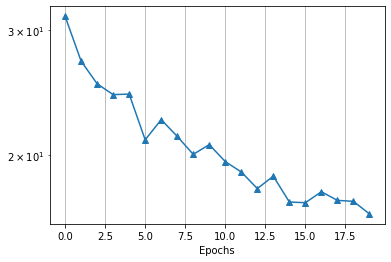

In [36]:
plt.plot(loss_history_end_epoch, "-^")
plt.yscale("log")
plt.xlabel("Epochs")
plt.grid(True)

In [37]:
acc_test, auc_test = test_acc_auc(beta, test_label, test_img_arr)

print(f'Test Accuracy is {acc_test:.2f}')
print(f'Test AUC is {auc_test:.2f}')

Test Accuracy is 0.55
Test AUC is 0.85


## Annealing

### Step Decay

In [38]:
n_epoch = 20
minibatch_size = 100 #size of the minibatchs
N = len(train_img)  #15000, total number of images
img_indices = np.arange(N)

loss_history = []
loss_history_end_epoch = []
beta = np.copy(beta_init)
learning_rate = 1e-6
lr_decay = 0.5

for epoch in range(n_epoch):
    # go through all the minibatches, sequetially
    start = time.time()
    n_minibatch = N // minibatch_size + 1
    # randomize the batches
    np.random.shuffle(img_indices)
    
    all_loss_within_epoch = []
    for k in range(n_minibatch):
        # create the minibatch of examples
        batch_indices = np.arange(k*minibatch_size, (k+1)*minibatch_size) % N
        batch_indices = img_indices[batch_indices]
        X_minibatch = train_img_arr[batch_indices]
        Y_minibatch = train_label[batch_indices]

        # compute the stochastic gradient
        val, grad = loss_LR_values_and_grad(beta, X_minibatch, Y_minibatch)

        # do one step of SGD
        beta = beta - learning_rate*grad

        # book-keeping
        loss_history.append(val)
        all_loss_within_epoch.append(val)
    loss_history_end_epoch.append(np.mean(all_loss_within_epoch))
    end = time.time()
    duration = end - start
    if (epoch + 1) % 5 == 0:
        learning_rate = learning_rate * lr_decay
    test_acc, _ = test_acc_auc(beta, test_label, test_img_arr)
    print(f"Epoch {epoch}: {duration:.2f} seconds, Loss: {loss_history_end_epoch[-1]:.2f}, Test Accuracy: {test_acc:.3f}")

Epoch 0: 1.91 seconds, Loss: 32.44, Test Accuracy: 0.462
Epoch 1: 1.79 seconds, Loss: 27.07, Test Accuracy: 0.575
Epoch 2: 1.98 seconds, Loss: 26.98, Test Accuracy: 0.578
Epoch 3: 1.92 seconds, Loss: 25.03, Test Accuracy: 0.536
Epoch 4: 1.87 seconds, Loss: 22.91, Test Accuracy: 0.471
Epoch 5: 1.77 seconds, Loss: 7.26, Test Accuracy: 0.500
Epoch 6: 1.76 seconds, Loss: 6.83, Test Accuracy: 0.512
Epoch 7: 1.84 seconds, Loss: 8.00, Test Accuracy: 0.488
Epoch 8: 1.81 seconds, Loss: 7.78, Test Accuracy: 0.528
Epoch 9: 1.85 seconds, Loss: 7.71, Test Accuracy: 0.536
Epoch 10: 1.80 seconds, Loss: 4.38, Test Accuracy: 0.525
Epoch 11: 1.76 seconds, Loss: 4.19, Test Accuracy: 0.505
Epoch 12: 1.93 seconds, Loss: 4.03, Test Accuracy: 0.519
Epoch 13: 2.54 seconds, Loss: 3.90, Test Accuracy: 0.512
Epoch 14: 1.93 seconds, Loss: 3.71, Test Accuracy: 0.516
Epoch 15: 2.00 seconds, Loss: 3.41, Test Accuracy: 0.513
Epoch 16: 2.03 seconds, Loss: 3.36, Test Accuracy: 0.512
Epoch 17: 1.87 seconds, Loss: 3.30, 

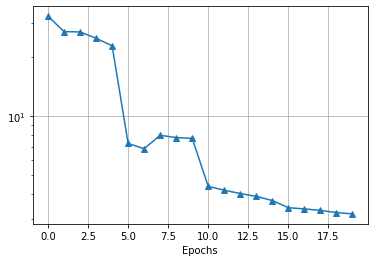

In [39]:
plt.plot(loss_history_end_epoch, "-^")
plt.yscale("log")
plt.xlabel("Epochs")
plt.grid(True)

In [40]:
acc_test, auc_test = test_acc_auc(beta, test_label, test_img_arr)

print(f'Test Accuracy is {acc_test:.2f}')
print(f'Test AUC is {auc_test:.2f}')

Test Accuracy is 0.52
Test AUC is 0.81


### Heuristic

In [44]:
# Create Validation Set for Heuristic
valid_img_arr = train_img_arr[14000:]
valid_label = train_label[14000:15000]

In [45]:
n_epoch = 20
minibatch_size = 100 #size of the minibatchs
N = len(train_img)  #15000, total number of images
img_indices = np.arange(N)

loss_history = []
loss_history_end_epoch = []
beta = np.copy(beta_init)
learning_rate = 1e-6
lr_decay = 0.5

for epoch in range(n_epoch):
    # go through all the minibatches, sequetially
    start = time.time()
    n_minibatch = N // minibatch_size + 1
    # randomize the batches
    np.random.shuffle(img_indices)
    
    all_loss_within_epoch = []
    for k in range(n_minibatch):
        # create the minibatch of examples
        batch_indices = np.arange(k*minibatch_size, (k+1)*minibatch_size) % N
        batch_indices = img_indices[batch_indices]
        X_minibatch = train_img_arr[batch_indices]
        Y_minibatch = train_label[batch_indices]

        # compute the stochastic gradient
        val, grad = loss_LR_values_and_grad(beta, X_minibatch, Y_minibatch)

        # do one step of SGD
        beta = beta - learning_rate*grad

        # book-keeping
        loss_history.append(val)
        all_loss_within_epoch.append(val)
    loss_history_end_epoch.append(np.mean(all_loss_within_epoch))
    end = time.time()
    duration = end - start

    valid_acc_new, _ = test_acc_auc(beta, valid_label, valid_img_arr)
    if epoch == 0:
        valid_acc = valid_acc_new
    elif valid_acc_new < valid_acc:
        learning_rate = learning_rate * lr_decay
    valid_acc = valid_acc_new
        
    print(f"Epoch {epoch}: {duration:.2f} seconds, Loss: {loss_history_end_epoch[-1]:.2f}, Validation Accuracy: {valid_acc:.3f}, LR: {learning_rate}")

Epoch 0: 3.50 seconds, Loss: 31.49, Validation Accuracy: 0.460, LR: 1e-06
Epoch 1: 2.19 seconds, Loss: 28.67, Validation Accuracy: 0.531, LR: 1e-06
Epoch 2: 2.02 seconds, Loss: 25.78, Validation Accuracy: 0.475, LR: 5e-07
Epoch 3: 1.90 seconds, Loss: 8.54, Validation Accuracy: 0.570, LR: 5e-07
Epoch 4: 1.79 seconds, Loss: 8.39, Validation Accuracy: 0.525, LR: 2.5e-07
Epoch 5: 1.85 seconds, Loss: 5.30, Validation Accuracy: 0.537, LR: 2.5e-07
Epoch 6: 1.95 seconds, Loss: 4.97, Validation Accuracy: 0.528, LR: 1.25e-07
Epoch 7: 2.38 seconds, Loss: 4.57, Validation Accuracy: 0.509, LR: 6.25e-08
Epoch 8: 1.95 seconds, Loss: 4.42, Validation Accuracy: 0.515, LR: 6.25e-08
Epoch 9: 2.09 seconds, Loss: 4.36, Validation Accuracy: 0.516, LR: 6.25e-08
Epoch 10: 1.93 seconds, Loss: 4.32, Validation Accuracy: 0.516, LR: 6.25e-08
Epoch 11: 2.13 seconds, Loss: 4.24, Validation Accuracy: 0.513, LR: 3.125e-08
Epoch 12: 2.01 seconds, Loss: 4.19, Validation Accuracy: 0.520, LR: 3.125e-08
Epoch 13: 1.81 sec

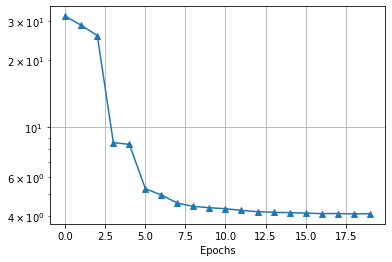

In [46]:
plt.plot(loss_history_end_epoch, "-^")
plt.yscale("log")
plt.xlabel("Epochs")
plt.grid(True)

In [47]:
acc_test, auc_test = test_acc_auc(beta, test_label, test_img_arr)

print(f'Test Accuracy is {acc_test:.2f}')
print(f'Test AUC is {auc_test:.2f}')

Test Accuracy is 0.52
Test AUC is 0.78


### 1/t decay

In [ ]:
### To be completed...

## Momentum a.k.a Heavy Ball Method

In [ ]:
### To be completed...